# Double Trouble Pendulum

The `SwiftyTwoLinks` and `KotlyOtlyDobleDosLinks` apps embed a custom motion simulation that solves a systems of dynamic equations for a double pendulum.
This Jupyter Notebook demonstrates how those equations may be determined using the `sympy.physics.mechanics` toolkit.
Each step of the process including importing required modules, defining symbolic constants and variables, translational and rotational kinematics, deriving equations of motion, and simulating is included.
Furthermore, the `matplotlib` visualisation module is used to plot states, and create a plot that is used in the application icon.

## Preliminaries

The following modules are imported below, with their summary usage:
 - `sympy` for symbolic algebra
 - `sympy.physics.mechanics` for kinematics and equation of motion derivation
 - `scipy.integrate` for simulating the system of differential equations
 - `numpy` for array manipulation
 - `IPython.display` for rendering equations
 - `matplotlib.pyplot` for plotting

In [1]:
from sympy import *
from sympy.physics.mechanics import *
from scipy.integrate import solve_ivp
import numpy as np
from IPython.display import display, Latex
import matplotlib.pyplot as plt

The `mechanics_printing()` function is part of `sympy.physics.mechanics`. 
It reduces verbosity of the typeset equation by eliminateing $(t)$ from time dependent symbolic terms, and representing time-derivatives by an overdot $\dot{(\, \cdot \,)}$ instead of $\partial / \partial t$.
Once it is called as a function, as it is below, these conventions will be followed anytime the `display` function is invoked.

In [2]:
mechanics_printing()

A function named `dtex` is defined below that is used to display LaTeX formatted equations, either taking text-formatted inputs that the user defines, or symbolic equations derived by `sympy`.
It takes a variable number of arguments, and will place and equals sign between them.
Thus its intent is generally that the user may typeset a concise symbol on the left hand side, and the coinciding equation on the right.

In [3]:
def dtex(*args):
    tex = ''
    for arg in args:
        if isinstance(arg, str):
            # Handle string arguments
            tex += f'${arg}$ $\, = \,$ '
        else:
            # Handle SymPy arguments
            tex += f'${mlatex(arg)}$ $\, = \,$ '
    
    # Trim off the last equals sign
    tex = tex[:-10]  
    display(Latex(tex))    

## Modeling

Below the requisite kinematics and equations of motion are developed symbolically.

### Create Symbols

For a double pendulum, we define two angles, $\theta_0$ and $\theta_1$, and two angular rates, $\omega_0$ and $\omega_1$, where the index $0$ represents the first link, and the index $1$ represents the second link.
In `sympy.physics.mechanics` we create the time-varying states using the `dynamicsymbols` function, with a list of symbolic terms in string form as the argument.
The vectors $\boldsymbol{q}$ and $\boldsymbol{u}$ represent generalized coordinates and generalized speeds, in radians and radians/sec, respectively, where:

In [4]:
q = dynamicsymbols('\\theta_0, \\theta_1')  # Generalized coordinates (angles)
u = dynamicsymbols('\\omega_0, \\omega_1')  # Generalized speeds (rates)
dtex('\\boldsymbol{q}', q)
dtex('\\boldsymbol{u}', u)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Several symbolic constants are defined for the link dimensions, mass, gravity, and time.
The $l_k$ symbols denote length, $w_k$ denote width, $m_k$ denote mass, and $I_k$ denote moment of inertia about the axis of rotation evaluated at the link center of gravity (CG).


In [5]:
l0, w0, l1, w1 = symbols('l_0, w_0, l_1, w_1')  # Lengths and widths
m0, m1, I0, I1 = symbols('m_0, m_1, I_0, I_1')  # Masses and inertias
x0, x1 = symbols('x_0, x_1')  # Distances from centers of rotation to CGs
xp = symbols('x_p')  # Distance from first link to second link center of rotation
g, gx, gy = symbols('g, g_x, g_y')  # Gravitational acceleration
t = symbols('t')  # Time

## Create Initial Values and Constant Values

In [6]:
q0 = np.deg2rad(44), np.deg2rad(44)  # radians
u0 = 0.0, 0.0  # radians/second
constants = {
    l0: 0.2,  # Length of first link
    w0: 0.0508,  # Width of first link
    l1: 0.15,  # Length of second link
    w1: 0.0508,  # Width of second link
    m0: 0.1,  # Mass of first link
    m1: 0.1,  # Mass of second link
    I0: 5e-6,  # Moment of inertia of first link
    I1: 5e-6,  # Moment of inertia of second link
    xp: 0.2,  # Origin to outer pivot
    x0: 0.1,  # Origin to inner link CG
    x1: 0.075,  # Outer pivot to outer link CG
    g: 9.8,
    gy: 9.8,
    gx: 0.0
}

## Create Kinematic Equations

In [7]:
kd = [speed - diff(coord) for coord, speed in zip(q, u)]
dtex(Matrix([[0], [0]]), Matrix(kd))

<IPython.core.display.Latex object>

## Create Frames

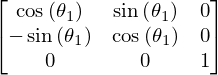

In [8]:
inertial = ReferenceFrame('N')

innerFrame = inertial.orientnew('A', 'axis', [q[0], inertial.z])
outerFrame = inertial.orientnew('B', 'axis', [q[1], inertial.z])

innerFrame.set_ang_vel(inertial, u[0] * inertial.z)
outerFrame.set_ang_vel(inertial, u[1] * inertial.z)

display(outerFrame.dcm(inertial))
display(outerFrame.ang_vel_in(inertial))

## Create Points

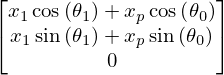

In [9]:
origin = Point('O')
origin.set_vel(inertial, Vector(0))

outerPivot = origin.locatenew('P', xp * innerFrame.x)
innerCG = origin.locatenew('0', x0 * innerFrame.x)
outerCG = outerPivot.locatenew('1', x1 * outerFrame.x)
innerEnd = innerCG.locatenew('A', 0.5 * l0 * innerFrame.x)
outerEnd = outerCG.locatenew('B', 0.5 * l1 * outerFrame.x)

outerPivot.v2pt_theory(origin, inertial, innerFrame)
innerCG.v2pt_theory(origin, inertial, innerFrame)
outerCG.v2pt_theory(outerPivot, inertial, outerFrame)

display(innerCG.pos_from(origin))
display(innerCG.vel(inertial))
display(outerCG.pos_from(origin))
display(outerCG.vel(inertial))
display(outerCG.pos_from(origin).to_matrix(inertial))

## Create Bodies

In [10]:
innerBody = Body('IB', masscenter=innerCG, mass=m0, frame=innerFrame, central_inertia=inertia(innerFrame, 0, 0, I0))
outerBody = Body('OB', masscenter=outerCG, mass=m1, frame=outerFrame, central_inertia=inertia(outerFrame, 0, 0, I1))
bodies = innerBody, outerBody

## Create Gravitational Load

In [11]:
gvector = gx * inertial.x - gy * inertial.y
loads = [
  (innerBody.masscenter, innerBody.mass * gvector),
  (outerBody.masscenter, outerBody.mass * gvector)
]

## Generate Equations of Motion

In [12]:
kane = KanesMethod(inertial, q, u, kd)
fr, frstar = kane.kanes_equations(bodies, loads)
dtex(simplify(fr), simplify(frstar))

<IPython.core.display.Latex object>

## Get the Simplified Mass Matrix

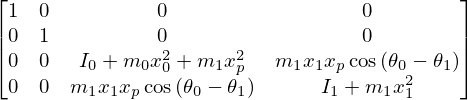

In [13]:
M = simplify(kane.mass_matrix_full)
display(M)

## Get the Simplified Forcing Vector

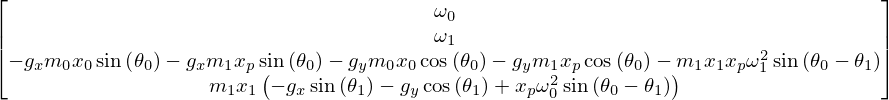

In [14]:
F = simplify(kane.forcing_full)
display(F)

## Create the Initial Value Problem (IVP)

In [15]:
massFunction = lambdify(q+u, M.subs(constants))
forcingFunction = lambdify(q+u, F.subs(constants))
def fun(t, x):
  mass = massFunction(*x)
  force = forcingFunction(*x)
  dxdt = np.linalg.inv(mass) @ force
  return dxdt[:, 0].tolist()

## Solve the IVP

In [16]:
sol = solve_ivp(fun, [0, 1.75], q0+u0, rtol=1e-9)

## Plot Angles and Rates

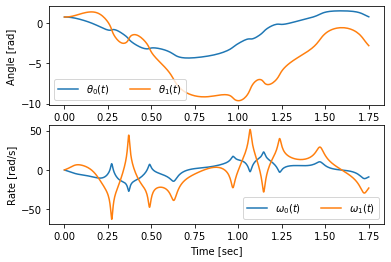

In [17]:
plt.subplot(2, 1, 1);
plt.plot(sol.t, sol.y[:2].transpose());
plt.ylabel('Angle [rad]');
plt.legend([f'${angle}$' for angle in q], ncol=2);

plt.subplot(2, 1, 2);
plt.plot(sol.t, sol.y[2:].transpose());
plt.xlabel('Time [sec]')
plt.ylabel('Rate [rad/s]');
plt.legend([f'${rate}$' for rate in u], ncol=2);

## Plot X-Y Position

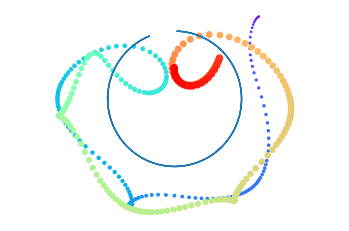

In [18]:
innerPosFcn = lambdify(q, innerEnd.pos_from(origin).to_matrix(inertial).transpose().subs(constants).tolist()[0])
outerPosFcn = lambdify(q, outerEnd.pos_from(origin).to_matrix(inertial).transpose().subs(constants).tolist()[0])

innerPos = np.array([innerPosFcn(*q) for q in sol.y[:2].transpose()])
outerPos = np.array([outerPosFcn(*q) for q in sol.y[:2].transpose()])

plt.plot(innerPos[:, 0], innerPos[:, 1]);
plt.scatter(outerPos[:, 0], outerPos[:, 1], 
            s=8*sol.t*3.14, c=sol.t, cmap='rainbow');
plt.axis('off');
plt.xlim([-0.5, 0.5])
plt.tight_layout;

plt.savefig('links.pdf')